<a href="https://colab.research.google.com/github/limited-fion/deep-learning-cw/blob/master/06_cw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set up libraries and functions

In [32]:
import numpy as np
import keras
np.random.seed(123)  # for reproducibility
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Conv2D,Reshape, Flatten, BatchNormalization, UpSampling2D

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
from keras.datasets import mnist, cifar10
from tensorflow.keras.layers.experimental import preprocessing
from skimage.transform import resize
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from google.colab import drive
import os
drive.mount('/content/drive')

!wget https://github.com/trishume/OpenTuringCompiler/blob/master/stdlib-sfml/fonts/Times%20New%20Roman.ttf

font_files = fm.findSystemFonts()

# Go through and add each to Matplotlib's font cache.
for font_file in font_files:
    fm.fontManager.addfont(font_file)

# Use your new font on all your plots.
plt.rc('font', family='serif')

def predict_representation(model, data, layer_name='representation'):
  ## We form a new model. Instead of doing \psi\phi(x), we only take \phi(x)
  ## To do so, we use the layer name
  intermediate_layer_model = Model(inputs=model.input,
                                   outputs=model.get_layer(layer_name).output)
  representation = intermediate_layer_model.predict(data)
  representation = representation.reshape(representation.shape[0], -1)
  return representation

def plot_representation_label(representation, labels, plot3d=0):
  ## Function used to plot the representation vectors and assign different 
  ## colors to the different classes

  # First create the figure
  fig, ax = plt.subplots(figsize=(10,6))
  # In case representation dimension is 3, we can plot in a 3d projection too
  if plot3d:
    ax = fig.add_subplot(111, projection='3d')
    
  # Check number of labels to separate by colors
  n_labels = labels.max() + 1
  # Color map, and give different colors to every label
  cm = plt.get_cmap('gist_rainbow')
  ax.set_prop_cycle(color=[cm(1.*i/(n_labels)) for i in range(n_labels)])
  # Loop is to plot different color for each label
  for l in range(n_labels):
    # Only select indices for corresponding label
    ind = labels == l
    if plot3d:
      ax.scatter(representation[ind, 0], representation[ind, 1], 
                 representation[ind, 2], label=str(l))
    else:
      ax.scatter(representation[ind, 0], representation[ind, 1], label=str(l))
  ax.legend()
  plt.title('Features in the representation space with corresponding label')
  plt.show()
  return fig, ax

def plot_recons_original(image, label, model, size_image=(28,28)):
  ## Function used to plot image x and reconstructed image \psi\phi(x)
  # Reshape (just in case) and predict using model
  if len(image.shape) == 1:
    image = image.reshape(1, -1)
  reconst_image = model.predict(image)
  # Evaluate MSE to also report it in the image
  mse = model.evaluate(image, image, verbose=0)
  # Create a figure with 1 row and 2 columns
  plt.subplots(1,2)
  # Select first image in the figure
  ax = plt.subplot(121)
  # Plot image x
  plt.imshow(image.reshape(size_image[0],size_image[1]), cmap='gray')
  # This removes the ticks in the axis
  ax.set_xticks([])
  ax.set_yticks([])
  # Select second image in the figure
  ax = plt.subplot(122)
  # Plot reconstructed image
  plt.imshow(reconst_image.reshape(size_image[0],size_image[1]), cmap='gray')
  # This removes the ticks in the axis
  ax.set_xticks([])
  ax.set_yticks([])
  # Set a title to the current axis (second figure)
  plt.title('MSE of {:.2f}'.format(mse[0]))
  plt.show()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
--2023-03-10 16:28:01--  https://github.com/trishume/OpenTuringCompiler/blob/master/stdlib-sfml/fonts/Times%20New%20Roman.ttf
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘Times New Roman.ttf.1’

Times New Roman.ttf     [ <=>                ] 137.48K  --.-KB/s    in 0.02s   

2023-03-10 16:28:02 (6.22 MB/s) - ‘Times New Roman.ttf.1’ saved [140776]



# Task 1

In [1]:
num_classes = 10

# Use x_test as your validation set
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train= x_train.astype('float32')
x_test= x_test.astype('float32')
x_train /= 255.
x_test /= 255.
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2],1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2],1)
x_train_32 = np.zeros((x_train.shape[0], 32,32,1))
x_test_32 = np.zeros((x_test.shape[0], 32,32,1))
# We resize the images
for n in range(x_train.shape[0]):
    x_train_32[n,:,:,:] = resize(x_train[n,:,:,:], (32,32,1), anti_aliasing=True)
for n in range(x_test.shape[0]):
    x_test_32[n,:,:,:] = resize(x_test[n,:,:,:], (32,32,1), anti_aliasing=True)

11490434/11490434 [==============================] - 1s 0us/step


## Without using any convolutional layer

In [2]:
### Modify the model here
autoencoder = Sequential()
autoencoder.add(Flatten(input_shape=(32,32,)))
# The representation has dimensionality 10, do not change the dimensionality
autoencoder.add(Dense(10, name='representation'))
autoencoder.add(Dense(32*32))
autoencoder.add(Reshape((32,32,1)))

autoencoder.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['mse'])
# You can modify the number of epochs or other hyperparameters
epochs = 20
history = autoencoder.fit(x_train_32, x_train_32, batch_size=128,
          epochs=epochs, verbose=1, validation_data=(x_test_32,x_test_32))

Epoch 1/20
469/469 [==============================] - 6s 4ms/step - loss: 0.0374 - mse: 0.0374 - val_loss: 0.0261 - val_mse: 0.0261
Epoch 2/20
469/469 [==============================] - 1s 3ms/step - loss: 0.0260 - mse: 0.0260 - val_loss: 0.0257 - val_mse: 0.0257
Epoch 3/20
469/469 [==============================] - 1s 3ms/step - loss: 0.0259 - mse: 0.0259 - val_loss: 0.0257 - val_mse: 0.0257
Epoch 4/20
469/469 [==============================] - 1s 3ms/step - loss: 0.0259 - mse: 0.0259 - val_loss: 0.0257 - val_mse: 0.0257
Epoch 5/20
469/469 [==============================] - 1s 3ms/step - loss: 0.0259 - mse: 0.0259 - val_loss: 0.0257 - val_mse: 0.0257
Epoch 6/20
469/469 [==============================] - 2s 3ms/step - loss: 0.0259 - mse: 0.0259 - val_loss: 0.0257 - val_mse: 0.0257
Epoch 7/20
469/469 [==============================] - 2s 3ms/step - loss: 0.0259 - mse: 0.0259 - val_loss: 0.0257 - val_mse: 0.0257
Epoch 8/20
469/469 [==============================] - 2s 4ms/step - loss: 0.

## Convolutional autoencoder

In [6]:
### Modify the model here
### This is an example of a simple/bad convolutional autoencoder
conv_autoencoder = Sequential()
conv_autoencoder.add(Conv2D(32, 3, strides=2, padding='same'))
conv_autoencoder.add(Flatten())
# The representation has dimensionality 10, do not change the dimensionality
conv_autoencoder.add(Dense(10, name='representation'))
conv_autoencoder.add(Dense(1*16*16))
conv_autoencoder.add(Reshape((16,16,1)))
conv_autoencoder.add(UpSampling2D((2, 2)))

conv_autoencoder.build((None,32,32,1))
conv_autoencoder.summary()
conv_autoencoder.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['mse'])
# You can modify the number of epochs or other hyperparameters
epochs = 20
history = conv_autoencoder.fit(x_train_32, x_train_32, batch_size=128,
          epochs=epochs, verbose=1, validation_data=(x_test_32,x_test_32))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 32)        320       
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 representation (Dense)      (None, 10)                81930     
                                                                 
 dense_1 (Dense)             (None, 256)               2816      
                                                                 
 reshape_1 (Reshape)         (None, 16, 16, 1)         0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 32, 32, 1)        0         
 )                                                               
                                                      

## Classifier 

In [7]:
pca = PCA(n_components=10)
pca = pca.fit(x_train_32.reshape(x_train_32.shape[0], -1))

## We compute the representations for the different methods
representation_pca_train = pca.transform(x_train_32.reshape(x_train_32.shape[0], -1))
representation_pca_test = pca.transform(x_test_32.reshape(x_test_32.shape[0], -1))
# predict_representation is defined at the beginning of this notebook
representation_auto_train = predict_representation(autoencoder, x_train_32)
representation_auto_test = predict_representation(autoencoder, x_test_32)
representation_conv_auto_train = predict_representation(conv_autoencoder, x_train_32)
representation_conv_auto_test = predict_representation(conv_autoencoder, x_test_32)

# We compute the MSE for the PCA method
reconst_train = pca.inverse_transform(representation_pca_train).reshape(x_train_32.shape[0], 32,32,1)
train_mse_pca = ((reconst_train - x_train_32)**2).mean()

reconst_test = pca.inverse_transform(representation_pca_test).reshape(x_test_32.shape[0], 32,32,1)
test_mse_pca = ((reconst_test - x_test_32)**2).mean()
# We print the MSE for PCA, which you need to include on the table
print("PCA MSE: x_train {:.4f} - x_test {:.4f}".format(train_mse_pca, test_mse_pca))


num_classes = 10

### Use always this linear classifier, do not modify it
classifier = Sequential()
classifier.add(Dense(10, activation='softmax'))
classifier.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])
epochs = 30
history = classifier.fit(representation_pca_train, y_train, batch_size=128,
          epochs=epochs, verbose=1, validation_data=(representation_pca_test,y_test))


313/313 [==============================] - 0s 1ms/step
PCA MSE: x_train 0.0258 - x_test 0.0256
Epoch 1/30
469/469 [==============================] - 2s 3ms/step - loss: 1.9771 - acc: 0.3945 - val_loss: 1.2304 - val_acc: 0.5889
Epoch 2/30
469/469 [==============================] - 1s 3ms/step - loss: 0.9985 - acc: 0.6847 - val_loss: 0.8263 - val_acc: 0.7571
Epoch 3/30
469/469 [==============================] - 1s 3ms/step - loss: 0.7808 - acc: 0.7649 - val_loss: 0.7123 - val_acc: 0.7850
Epoch 4/30
469/469 [==============================] - 1s 3ms/step - loss: 0.7040 - acc: 0.7818 - val_loss: 0.6623 - val_acc: 0.7951
Epoch 5/30
469/469 [==============================] - 1s 3ms/step - loss: 0.6662 - acc: 0.7897 - val_loss: 0.6356 - val_acc: 0.8017
Epoch 6/30
469/469 [==============================] - 1s 3ms/step - loss: 0.6444 - acc: 0.7944 - val_loss: 0.6193 - val_acc: 0.8048
Epoch 7/30
469/469 [==============================] - 1s 3ms/step - loss: 0.6306 - acc: 0.7979 - val_loss: 0.6084

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.014s...
[t-SNE] Computed neighbors for 10000 samples in 1.507s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.563892
[t-SNE] KL divergence after 250 iterations with early exaggeration: 84.069153
[t-SNE] KL divergence after 500 iterations: 1.903015


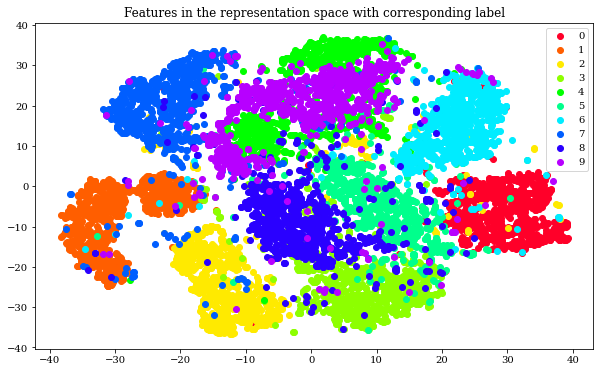

(<Figure size 720x432 with 1 Axes>,
 <AxesSubplot:title={'center':'Features in the representation space with corresponding label'}>)

In [33]:
## We use tSNE for our dimensionality reduction technique so we can
## plot the features using a 2D plot as it leads to nice plots.
## However, tSNE is tricky to use as a general dimensionality reduction method
## for clustering due to issues mentioned here: https://distill.pub/2016/misread-tsne/
## TSNE: https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding
## Nice article explaining shortcomings: https://distill.pub/2016/misread-tsne/
from sklearn.manifold import TSNE

## Use these parameters, the plots are highly dependent on perplexity value
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=500,n_jobs=8)
representation_tsne = tsne.fit_transform(representation_auto_test)
plot_representation_label(representation_tsne, y_test)

1/1 [==============================] - 0s 25ms/step


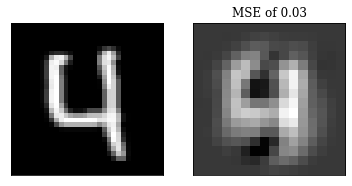

In [36]:
ind = np.random.randint(x_test.shape[0] -  1)
## The function below is defined in the tutorial
plot_recons_original(np.expand_dims(x_test_32[ind],0), y_test[ind], conv_autoencoder, size_image=(32,32))